Còdecs: blosclz i zstd
    
CONCLUSIONS: no es solapen

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import aux_funcs
from pathlib import Path

## Collect data from 3 different containers

30: entropy shuffle (split)

0: blosclz shuffle split

1: zstd shuffle split

In [2]:
paths = [Path('../data_inputs_temp/'),
         Path('../data_inputs'),
         Path('../data_inputs_wind/')]

files = ['entropy-shuffle', 'blosclz-shuffle-split', 'zstd-shuffle-split']
categories = ["30", "0", "1"]

df_entropy = aux_funcs.get_df_by_category(paths, files[0], categories[0])
df_blosclz = aux_funcs.get_df_by_category(paths, files[1], categories[1])
df_zstd = aux_funcs.get_df_by_category(paths, files[2], categories[2])

In [3]:
df_shuffle = pd.concat([df_blosclz, df_zstd, df_entropy], axis=1)

# Filter data

Delete data corresponding to special values chunks.

In [4]:
df_shuffle = aux_funcs.delete_special_vals(df_shuffle, ["special_vals0", "special_vals1", "special_vals30"])
df_input_x = df_shuffle.iloc[:, [6, 7]]

## Compute best category

In [5]:
df_codecs = df_shuffle.drop(['cratio30', 'speed30', 'special_vals30', 'special_vals0', 'special_vals1'], axis = 1)

### Normalize cratio and speed

In [6]:
dfcratios = pd.concat([df_codecs.iloc[:, 0], df_codecs.iloc[:, 2]], axis=0)
mean_cratio = dfcratios.mean()

cratio0 = df_codecs["cratio0"]
cratio1 = df_codecs["cratio1"]

ncratio0 = cratio0 - mean_cratio
ncratio1 = cratio1 - mean_cratio
all_cratios = np.concatenate((ncratio0, ncratio1), axis=0)

std_cratio = all_cratios.std()
ncratio0 /= std_cratio
ncratio1 /= std_cratio

In [7]:
dfspeeds = pd.concat([df_codecs.iloc[:, 1], df_codecs.iloc[:, 3]], axis =0)
mean_speed = dfspeeds.mean()

speed0 = df_codecs["speed0"]
speed1 = df_codecs["speed1"]

nspeed0 = speed0 - mean_speed
nspeed1 = speed1 - mean_speed
all_speeds = np.concatenate((nspeed0, nspeed1), axis=0)

dsv_speed = all_speeds.std()
nspeed0 /= dsv_speed
nspeed1 /= dsv_speed

### Compute score to determine which category is the best one

In [8]:
theta = 0.95

df_score_balance = pd.DataFrame()
df_score_balance.insert(0, 0, theta*ncratio0 + (1-theta)*nspeed0)
df_score_balance.insert(1, 1, theta*ncratio1 + (1-theta)*nspeed1)

In [9]:
best_categ_shuffle = pd.DataFrame(df_score_balance.idxmax(axis=1), columns=['best_categ'])

categories = best_categ_shuffle['best_categ'].unique()
if len(categories) <= 1:
    raise ValueError("To train the data at least two possible categories must be provided")

In [10]:
df_t = pd.DataFrame()
df_t = pd.concat([df_t, df_input_x['cratio30']], axis = 1)
df_t = pd.concat([df_t, df_input_x['speed30']], axis = 1)
df_t = pd.concat([df_t, best_categ_shuffle], axis = 1)

## Split data into training and test

Create a balanced training data with same amount of samples for each (best) category

In [11]:
df_blc = pd.DataFrame()
df_test = pd.DataFrame()
nsamples = min(len(df_t[df_t['best_categ'] == categories[0]]),
               len(df_t[df_t['best_categ'] == categories[1]])) - 2000
if nsamples <= 0:
    raise RuntimeError("not enough data")
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_blc = pd.concat([df_blc, df_i.head(n=nsamples)], axis = 0)
    df_test = pd.concat([df_test, df_i.iloc[nsamples:, :]], axis = 0)

In [12]:
dftrain_y = df_blc['best_categ']
dftrain_x = df_blc.drop(['best_categ'], axis=1)

In [13]:
dftest_y = df_test['best_categ']
dftest_x = df_test.drop(['best_categ'], axis=1)

## Normalize entropy data

In [14]:
dfcratios = dftrain_x.iloc[:, 0]
mean_cratio = dfcratios.mean()

cratio = dftrain_x["cratio30"]
cratio_mean = cratio.mean()
ncratio = cratio - cratio_mean
dsv_cratio = ncratio.std()
ncratio /= dsv_cratio

In [15]:
dfspeeds = dftrain_x.iloc[:, 1]
mean_speed = dfspeeds.mean()

speed = dftrain_x["speed30"]
speed_mean = speed.mean()
nspeed = speed - speed_mean
dvs_speed = nspeed.std()
nspeed /= dvs_speed

In [16]:
dftrain_x_norm = pd.DataFrame()
dftrain_x_norm.insert(0, "ncratio", ncratio)
dftrain_x_norm.insert(1, "nspeed", nspeed)
dftrain_x = dftrain_x_norm

# Normalize test data with train statistics
cratio_test = dftest_x["cratio30"]
speed_test = dftest_x["speed30"]
ncratio_test = cratio_test - cratio_mean
ncratio_test /= dsv_cratio
nspeed_test = speed_test - speed_mean
nspeed_test /= dvs_speed

dftest_x_norm = pd.DataFrame()
dftest_x_norm.insert(0, "ncratio", ncratio_test)
dftest_x_norm.insert(1, "nspeed", nspeed_test)

# Neural Network with 2 categories

## Build model

In [17]:
from keras.utils import to_categorical
dftrain_y = to_categorical(dftrain_y)
dftest_y = to_categorical(dftest_y)


2023-01-02 08:57:36.623465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
from keras import models, layers
import tensorflow

tensorflow.random.set_seed(100)

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

2023-01-02 08:57:42.528467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Train it with data

In [20]:
history = model.fit(dftrain_x, dftrain_y, epochs=30, validation_split=0.1)

Epoch 1/30
1216/1216 [==============================] - 4s 2ms/step - loss: 0.4657 - acc: 0.8147 - val_loss: 0.3683 - val_acc: 0.9671

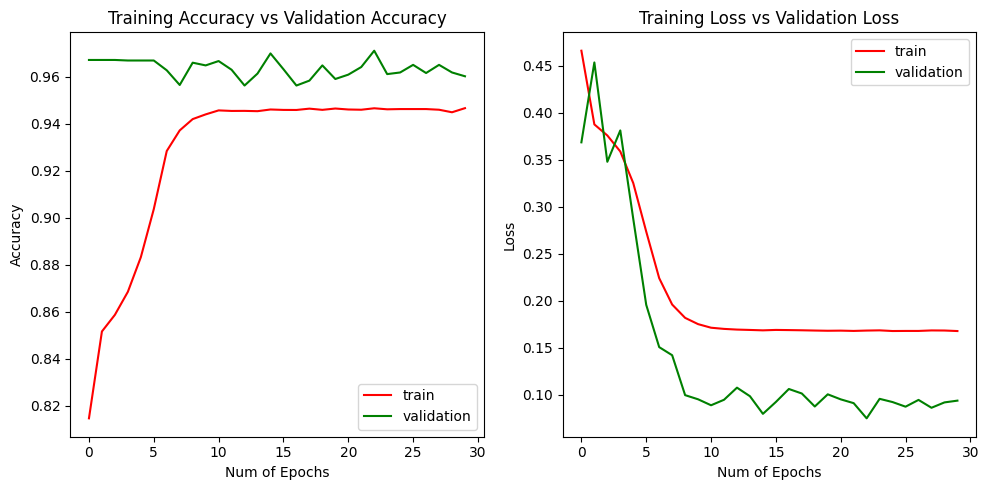

In [21]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history.history['acc'], 'r')
ax[0].plot(history.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history.history['loss'], 'r')
ax[1].plot(history.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

Rebuild model until epoch x.

In [22]:
model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(dftrain_x, dftrain_y, epochs=10, validation_split=0.1)

Epoch 1/10
1216/1216 [==============================] - 3s 2ms/step - loss: 0.4589 - acc: 0.8173 - val_loss: 0.3464 - val_acc: 0.9671

### Predict train data

In [23]:
y_hat = model.predict(x=dftrain_x)

1351/1351 [==============================] - 2s 1ms/step

In [24]:
y_pred_label = np.argmax(y_hat, axis = 1)
y_true_label = np.argmax(dftrain_y, axis = 1)

In [25]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1
row_0,,
0,20511,1078
1,1090,20523


In [26]:
(table[0][0] + table[1][1]) / np.sum(table.sum())

0.9498171380954585

### Predict test data

In [27]:
predictions = model.predict(x=dftest_x)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(dftest_y, axis=1)

1086/1086 [==============================] - 1s 1ms/step

In [28]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1
row_0,,
1,2000,32723


In [29]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score = (len(aux) - fails) / len(aux)
score


0.9424012902110993